Mounted at /content/drive
Dataset loaded, sample data:
                                             content sentiment
0  Wants to know how the hell I can remember word...     happy
1  Love is a long sweet dream & marriage is an al...     happy
2  The world could be amazing when you are slight...     happy
3  My secret talent is getting tired without doin...     happy
4  Khatarnaak Whatsapp Status Ever… Can\’t talk, ...     happy

Training tokenizer with vocab_size=500 ...
vocab=500: mean tokens=24.723, 95th%=44.0

Training tokenizer with vocab_size=1000 ...
vocab=1000: mean tokens=20.881, 95th%=37.0

Training tokenizer with vocab_size=2000 ...
vocab=2000: mean tokens=18.141, 95th%=32.6

Training tokenizer with vocab_size=5000 ...
vocab=5000: mean tokens=15.922, 95th%=29.0


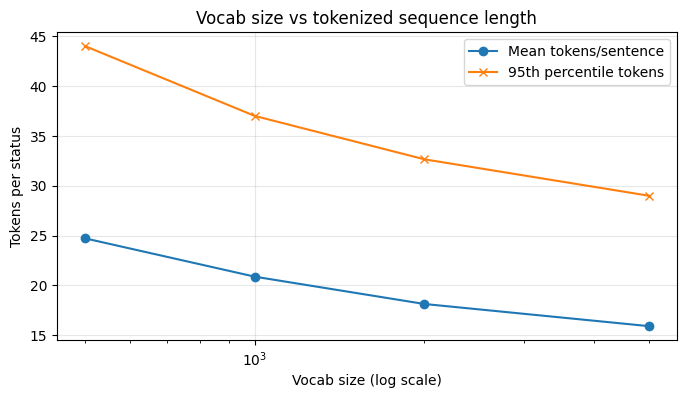


Heuristic-selected best_vocab = 2000 (you can override manually)
Recommendation: For small WhatsApp-status datasets, 1k-2k is typically a good sweet-spot.
Using vocab_size=2000
Total tokens: 12844, train tokens: 11559, val tokens: 1285
Training Original Mini-GPT...
Epoch 0, Loss 7.7674
Epoch 10000, Loss 0.6581
Epoch 20000, Loss 0.5895
Epoch 30000, Loss 0.8395
Epoch 40000, Loss 0.6792
Epoch 50000, Loss 0.5678
Epoch 60000, Loss 0.6150
Epoch 70000, Loss 0.5120
Epoch 80000, Loss 0.4484
Epoch 90000, Loss 0.4061
Epoch 100000, Loss 0.3891
Epoch 110000, Loss 0.5065
Epoch 120000, Loss 0.7347
Epoch 130000, Loss 0.5833
Epoch 140000, Loss 0.5067
Epoch 150000, Loss 0.4562

Training Deep-and-Thin Mini-GPT...
Epoch 0, Loss 7.6501
Epoch 10000, Loss 2.0354
Epoch 20000, Loss 2.0365
Epoch 30000, Loss 1.8228
Epoch 40000, Loss 1.9729
Epoch 50000, Loss 1.3490
Epoch 60000, Loss 1.3764
Epoch 70000, Loss 1.2044
Epoch 80000, Loss 1.2774
Epoch 90000, Loss 1.4113
Epoch 100000, Loss 1.1606
Epoch 110000, Loss 1.23

In [ ]:
# Paste into Colab cell (run after you pip install tokenizers)
!pip install -q tokenizers

# ================================
# Integrated: BPE vocab search + Mini-GPT training
# ================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from tokenizers.processors import TemplateProcessing
from collections import defaultdict
import pandas as pd
from google.colab import drive

# ------------------
# 0️⃣ reproducibility & device
# ------------------
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ------------------
# 1️⃣ Mount Google Drive & Load CSV
# ------------------
drive.mount('/content/drive')

csv_path = "/content/drive/My Drive/Colab Notebooks/MinIGPT/Emotion(happy).csv"
df = pd.read_csv(csv_path)
print("Dataset loaded, sample data:")
print(df.head())

# Use the 'content' column as text data
texts = df['content'].astype(str).tolist()
# Optional: small preprocessing (strip)
texts = [t.strip() for t in texts if len(t.strip())>0]

# ------------------
# 2️⃣ Helper: train BPE tokenizer and compute lengths
# ------------------
def train_bpe_tokenizer(corpus_iterator, vocab_size, special_tokens=None):
    """
    Train a BPE tokenizer (tokenizers library) and return the tokenizer object.
    corpus_iterator : iterable of str
    """
    if special_tokens is None:
        special_tokens = ["<pad>", "<unk>", "<bos>", "<eos>"]
    tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=special_tokens)
    tokenizer.train_from_iterator(corpus_iterator, trainer=trainer)
    # Set post-processor for adding BOS/EOS tokens (optional)
    tokenizer.post_processor = TemplateProcessing(
        single="$A",
        pair="$A $B",
        special_tokens=[]
    )
    return tokenizer

def corpus_token_stats(tokenizer, corpus):
    lens = []
    for t in corpus:
        enc = tokenizer.encode(t)
        lens.append(len(enc.ids))
    arr = np.array(lens)
    return float(arr.mean()), float(np.percentile(arr, 95)), lens

# ------------------
# 3️⃣ Try multiple vocab sizes and plot
# ------------------
vocab_candidates = [500, 1000, 2000, 5000]    # adjust if you want more tries
results = {}

for vs in vocab_candidates:
    print(f"\nTraining tokenizer with vocab_size={vs} ...")
    tok = train_bpe_tokenizer(texts, vocab_size=vs)
    mean_len, p95_len, lens = corpus_token_stats(tok, texts)
    results[vs] = {'tokenizer': tok, 'mean': mean_len, 'p95': p95_len, 'lens': lens}
    print(f"vocab={vs}: mean tokens={mean_len:.3f}, 95th%={p95_len:.1f}")

# Plot
means = [results[v]['mean'] for v in vocab_candidates]
p95s  = [results[v]['p95'] for v in vocab_candidates]

plt.figure(figsize=(8,4))
plt.plot(vocab_candidates, means, marker='o', label='Mean tokens/sentence')
plt.plot(vocab_candidates, p95s, marker='x', label='95th percentile tokens')
plt.xscale('log')
plt.xlabel('Vocab size (log scale)')
plt.ylabel('Tokens per status')
plt.title('Vocab size vs tokenized sequence length')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ------------------
# 4️⃣ Heuristic to pick "best" vocab (elbow)
# ------------------
# Compute relative improvements in mean as vocab grows
sorted_vs = sorted(vocab_candidates)
means_sorted = [results[v]['mean'] for v in sorted_vs]
marginal_reduction = []
for i in range(1, len(means_sorted)):
    prev = means_sorted[i-1]
    cur = means_sorted[i]
    reduction = (prev - cur) / prev if prev>0 else 0.0
    marginal_reduction.append(reduction)

# choose first vocab where marginal_reduction < threshold (tiny gain)
marginal_threshold = 0.02   # 2% improvement threshold
best_idx = None
for i, red in enumerate(marginal_reduction, start=1):
    if red < marginal_threshold:
        best_idx = i
        break
if best_idx is None:
    # fallback: choose vocab with best tradeoff (here choose the middle / 2k if present)
    if 2000 in sorted_vs:
        best_vocab = 2000
    else:
        best_vocab = sorted_vs[-1]
else:
    best_vocab = sorted_vs[best_idx]

print(f"\nHeuristic-selected best_vocab = {best_vocab} (you can override manually)")

# Provide an alternate simpler suggestion: if your dataset tiny, 1k-2k recommended
print("Recommendation: For small WhatsApp-status datasets, 1k-2k is typically a good sweet-spot.")

# ------------------
# 5️⃣ Use selected tokenizer and build tokenized dataset for model
# ------------------
tokenizer = results[best_vocab]['tokenizer']
vocab_size = tokenizer.get_vocab_size()
print(f"Using vocab_size={vocab_size}")

# Encode full_text into a single long sequence (like original approach),
# join texts with a newline token so sentences don't collide. Using '\n' string.
# The tokenizer splits on whitespace so newline is fine.
joined = "\n".join(texts)
encoded = tokenizer.encode(joined).ids
data = torch.tensor(encoded, dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]
print(f"Total tokens: {len(data)}, train tokens: {len(train_data)}, val tokens: {len(val_data)}")

# Replace original encode/decode with tokenizer wrappers
def encode_str(s):
    return tokenizer.encode(s).ids

def decode_ids(l):
    # tokenizers expect python list of ints
    return tokenizer.decode(l)

# ------------------
# 6️⃣ Data loader (unchanged except now tokens are BPE ids)
# ------------------
def get_batch(data, batch_size, block_size):
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# ------------------
# 7️⃣ (Your transformer code) — copy/paste exactly from your original cells
#    (Heads, MultiHeadAttention, Blocks, SwiGLU, GPT classes)
#    For brevity here we re-use your classes — ensure they are defined in this cell
# ------------------

# --- Paste your Head, MultiHeadAttention, FeedForward, Block, SwiGLU, BlockSwiGLU, MiniGPT, MiniGPTSwiGLU, MiniGPTSwiGLU_Shared here ---
# For brevity in this example I'll re-define them in-line (identical to your code).
# (Please replace with the exact classes you shared — they are the same as below.)

class Head(nn.Module):
    def __init__(self, head_size, embedding_dim, block_size):
        super().__init__()
        self.key = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.value = nn.Linear(embedding_dim, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, embedding_dim, dropout, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, embedding_dim, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads*head_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, embedding_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4*embedding_dim),
            nn.ReLU(),
            nn.Linear(4*embedding_dim, embedding_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, embedding_dim, n_heads, dropout, block_size):
        super().__init__()
        head_size = embedding_dim // n_heads
        self.sa = MultiHeadAttention(n_heads, head_size, embedding_dim, dropout, block_size)
        self.ffwd = FeedForward(embedding_dim, dropout)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class SwiGLU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.w1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.v = nn.Linear(hidden_dim, input_dim, bias=False)

    def forward(self, x):
        return self.v(self.w1(x) * torch.sigmoid(self.w2(x)))

class FeedForwardSwiGLU(nn.Module):
    def __init__(self, embedding_dim, dropout):
        super().__init__()
        hidden_dim = embedding_dim * 4
        self.net = nn.Sequential(
            SwiGLU(embedding_dim, hidden_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class BlockSwiGLU(nn.Module):
    def __init__(self, embedding_dim, n_heads, dropout, block_size):
        super().__init__()
        head_size = embedding_dim // n_heads
        self.sa = MultiHeadAttention(n_heads, head_size, embedding_dim, dropout, block_size)
        self.ffwd = FeedForwardSwiGLU(embedding_dim, dropout)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class MiniGPT(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding_table = nn.Embedding(block_size, embedding_dim)
        self.blocks = nn.Sequential(*[Block(embedding_dim, n_heads, dropout, block_size) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, vocab_size)
        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        idx = idx.to(torch.long)
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_idx), dim=1)
        return idx

class MiniGPTSwiGLU(MiniGPT):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__(vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout)
        self.blocks = nn.Sequential(*[
            BlockSwiGLU(embedding_dim, n_heads, dropout, block_size) for _ in range(n_layers)
        ])

class MiniGPTSwiGLU_Shared(MiniGPT):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__(vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout)
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)
        shared_block = BlockSwiGLU(embedding_dim, n_heads, dropout, block_size)
        self.blocks = nn.ModuleList([shared_block for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, vocab_size, bias=False)
        self.lm_head.weight = self.token_embedding_table.weight
        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        idx = idx.to(torch.long)
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

# ------------------
# 8️⃣ Training helper (unchanged)
# ------------------
def train_model(model_class, config, train_data, val_data, epochs=200):
    model = model_class(
        vocab_size=vocab_size,
        embedding_dim=config['embedding_dim'],
        n_layers=config['n_layers'],
        n_heads=config['n_heads'],
        block_size=config['block_size'],
        dropout=config['dropout']
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    train_losses = []
    for epoch in range(epochs):
        xb, yb = get_batch(train_data, config['batch_size'], config['block_size'])
        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if epoch % 10000 == 0:
            print(f"Epoch {epoch}, Loss {loss.item():.4f}")
    # Validation
    xb, yb = get_batch(val_data, config['batch_size'], config['block_size'])
    with torch.no_grad():
        _, val_loss = model(xb, yb)
    perplexity = torch.exp(val_loss).item()
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return model, train_losses, val_loss.item(), perplexity, param_count

# ------------------
# 9️⃣ Configs (same as yours)
# ------------------
block_size = 16
dropout = 0.1
batch_size = 8
lr = 1e-2
epochs = 160000

original_config = {
    'embedding_dim': 64,
    'n_layers': 2,
    'n_heads': 4,
    'block_size': block_size,
    'dropout': dropout,
    'batch_size': batch_size,
    'lr': lr
}

deepthin_config = {
    'embedding_dim': 24,
    'n_layers': 8,
    'n_heads': 2,
    'block_size': block_size,
    'dropout': dropout,
    'batch_size': batch_size,
    'lr': lr
}

# ------------------
# 10️⃣ Train models (WARNING: long run if epochs large)
# ------------------
print("Training Original Mini-GPT...")
orig_model, orig_losses, orig_val_loss, orig_ppl, orig_params = train_model(MiniGPT, original_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin Mini-GPT...")
deep_model, deep_losses, deep_val_loss, deep_ppl, deep_params = train_model(MiniGPT, deepthin_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin Mini-GPT (SwiGLU)...")
deep_swiglu_model, deep_swiglu_losses, deep_swiglu_val_loss, deep_swiglu_ppl, deep_swiglu_params = train_model(MiniGPTSwiGLU, deepthin_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin SwiGLU (Shared)...")
shared_model, shared_losses, shared_val_loss, shared_ppl, shared_params = train_model(MiniGPTSwiGLU_Shared, deepthin_config, train_data, val_data, epochs)

# ------------------
# 11️⃣ Compare metrics & plot (unchanged)
# ------------------
print("\n===== Comparison =====")
print(f"Original Mini-GPT: Val Loss={orig_val_loss:.4f}, Perplexity={orig_ppl:.4f}, Params={orig_params}")
print(f"Deep-and-Thin GPT: Val Loss={deep_val_loss:.4f}, Perplexity={deep_ppl:.4f}, Params={deep_params}")
print(f"Deep-and-Thin GPT (SwiGLU): Val Loss={deep_swiglu_val_loss:.4f}, Perplexity={deep_swiglu_ppl:.4f}, Params={deep_swiglu_params}")
print(f"Deep-and-Thin SwiGLU (Shared): Val Loss={shared_val_loss:.4f}, Perplexity={shared_ppl:.4f}, Params={shared_params}")

plt.figure(figsize=(10,5))
plt.plot(orig_losses, label='Original (ReLU)')
plt.plot(deep_losses, label='Deep-Thin (ReLU)')
plt.plot(deep_swiglu_losses, label='Deep-Thin (SwiGLU)')
plt.plot(shared_losses, label='Deep-Thin SwiGLU (Shared)')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss Curves')
plt.show()

# ------------------
# 12️⃣ Generate demo continuations using tokenizer decode
# ------------------
prompt = "Happy "
context_ids = torch.tensor([encode_str(prompt)], dtype=torch.long, device=device)

gen_orig = orig_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_deep = deep_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_swiglu = deep_swiglu_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_shared = shared_model.generate(context_ids, max_new_tokens=100)[0].tolist()

print("\nGenerated by Original Mini-GPT:\n", decode_ids(gen_orig))
print("\nGenerated by Deep-and-Thin GPT:\n", decode_ids(gen_deep))
print("\nGenerated by Deep-and-Thin GPT (SwiGLU):\n", decode_ids(gen_swiglu))
print("\nGenerated by Deep-and-Thin SwiGLU (Shared):\n", decode_ids(gen_shared))


In [ ]:
# ------------------
# 12️⃣ Generate demo continuations using tokenizer decode
# ------------------
prompt = "Love is a long sweet "
context_ids = torch.tensor([encode_str(prompt)], dtype=torch.long, device=device)

gen_orig = orig_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_deep = deep_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_swiglu = deep_swiglu_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_shared = shared_model.generate(context_ids, max_new_tokens=100)[0].tolist()

print("\nGenerated by Original Mini-GPT:\n", decode_ids(gen_orig))
print("\nGenerated by Deep-and-Thin GPT:\n", decode_ids(gen_deep))
print("\nGenerated by Deep-and-Thin GPT (SwiGLU):\n", decode_ids(gen_swiglu))
print("\nGenerated by Deep-and-Thin SwiGLU (Shared):\n", decode_ids(gen_shared))


In [ ]:
# ------------------
# 12️⃣ Generate demo continuations using tokenizer decode
# ------------------
prompt = "Hello How are you "
context_ids = torch.tensor([encode_str(prompt)], dtype=torch.long, device=device)

gen_orig = orig_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_deep = deep_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_swiglu = deep_swiglu_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_shared = shared_model.generate(context_ids, max_new_tokens=100)[0].tolist()

print("\nGenerated by Original Mini-GPT:\n", decode_ids(gen_orig))
print("\nGenerated by Deep-and-Thin GPT:\n", decode_ids(gen_deep))
print("\nGenerated by Deep-and-Thin GPT (SwiGLU):\n", decode_ids(gen_swiglu))
print("\nGenerated by Deep-and-Thin SwiGLU (Shared):\n", decode_ids(gen_shared))


In [ ]:
# ------------------
# 12️⃣ Generate demo continuations using tokenizer decode
# ------------------
prompt = "The secret talent is  "
context_ids = torch.tensor([encode_str(prompt)], dtype=torch.long, device=device)

gen_orig = orig_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_deep = deep_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_swiglu = deep_swiglu_model.generate(context_ids, max_new_tokens=100)[0].tolist()
gen_shared = shared_model.generate(context_ids, max_new_tokens=100)[0].tolist()

print("\nGenerated by Original Mini-GPT:\n", decode_ids(gen_orig))
print("\nGenerated by Deep-and-Thin GPT:\n", decode_ids(gen_deep))
print("\nGenerated by Deep-and-Thin GPT (SwiGLU):\n", decode_ids(gen_swiglu))
print("\nGenerated by Deep-and-Thin SwiGLU (Shared):\n", decode_ids(gen_shared))


After running the cell above, please re-run the original code cell to download the dataset.